# Práctica 2. Reglas de asociación y análisis de componentes principales

* Rodríguez Fitta José Emanuel

## Ejercicio 1

* Utilizando el conjunto de datos Online Retail :
https://archive.ics.uci.edu/ml/datasets/online+retail
Obtener el conjunto de artículos frecuentes así como reglas de asociación que se puedan extraer del
mismo.


In [286]:
# importación de las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib import rcParams

from mlxtend.frequent_patterns import association_rules, apriori

rcParams['figure.figsize'] = 10, 5
warnings.filterwarnings('ignore')

In [295]:
# Carga de datos
df_retail = pd.read_csv('/content/Online Retail.csv')
df_retail.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom


Seguiremos como guía el código en R desarrollado en: https://datascienceplus.com/a-gentle-introduction-on-market-basket-analysis/

### Preprocesamiento y exploración de datos 

In [296]:
# Transformamos la columna "InvoiceDate" a datetime 64
df_retail['InvoiceDate'] = df_retail['InvoiceDate'].astype('datetime64')

In [298]:
# Extraemos la fecha y la hora de la columna "InvoiceDate"
df_retail['Date'] = df_retail['InvoiceDate'].dt.date
df_retail['Time'] = df_retail['InvoiceDate'].dt.hour

In [299]:
df_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
 8   Date         541909 non-null  object        
 9   Time         541909 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 41.3+ MB


In [300]:
df_retail.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
Date                0
Time                0
dtype: int64

Podemos observar que existe una gran cantidad de valores nulos. Por lo cual eliminaremos estas filas.

In [301]:
# Eliminamos las filas con valores nulos
df_retail.dropna(axis = 0, inplace = True)

In [302]:
df_retail.shape

(406829, 10)

El conjunto de datos contiene $406829$ filas y $10$ columnas:




In [303]:
df_retail.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Date', 'Time'],
      dtype='object')

### ¿A qué hora suelen hacerse órdenes online?

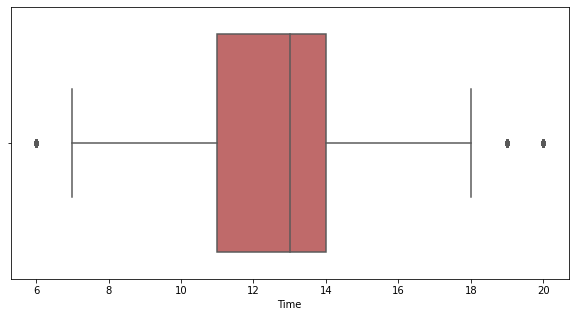

In [304]:
sns.boxplot(x = 'Time', data = df_retail, color = 'indianred')
plt.show()

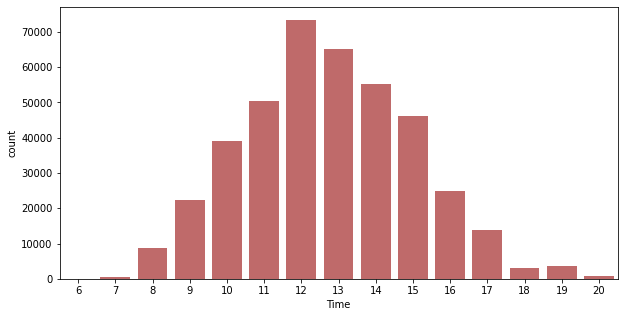

In [305]:
sns.countplot(x = 'Time', data = df_retail, color = 'indianred')
plt.show()

La mayor cantidad de ordenes sucede entre las 11:00 y las 14:00.

### ¿Cuántos objetos compra cada cliente?

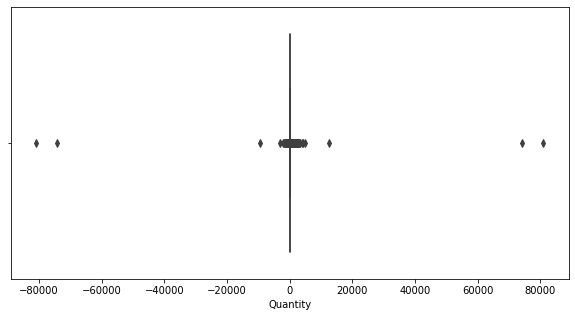

In [306]:
sns.boxplot(df_retail['Quantity'])
plt.show()

Existe una gran cantidad de valores atípicos

In [312]:
quantity = df_retail.groupby('InvoiceNo')['Quantity'].mean() 


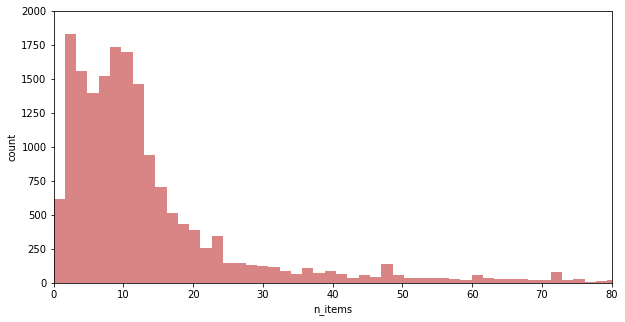

In [315]:
sns.histplot(quantity, color = 'indianred', bins = 100000)
plt.xlim(0, 80)
plt.ylim(0, 2000)
plt.xlabel('n_items')
plt.ylabel('count')
plt.show()



Las personas suelen comprar menos de $10$ objetos.



### Top $10$ best sellers

In [316]:
# Obtenemos 10 los objetos más comprados
description = df_retail.groupby(['StockCode', 'Description'])['StockCode'].count().sort_values(ascending = False)[:10]

In [317]:
description = pd.DataFrame(description).reset_index(level = 0, drop = True).reset_index()
description

,Description,StockCode
0,WHITE HANGING HEART T-LIGHT HOLDER,2070
1,REGENCY CAKESTAND 3 TIER,1905
2,JUMBO BAG RED RETROSPOT,1662
3,ASSORTED COLOUR BIRD ORNAMENT,1418
4,PARTY BUNTING,1416
5,LUNCH BAG RED RETROSPOT,1358
6,SET OF 3 CAKE TINS PANTRY DESIGN,1232
7,POSTAGE,1196
8,LUNCH BAG BLACK SKULL.,1126
9,PACK OF 72 RETROSPOT CAKE CASES,1080


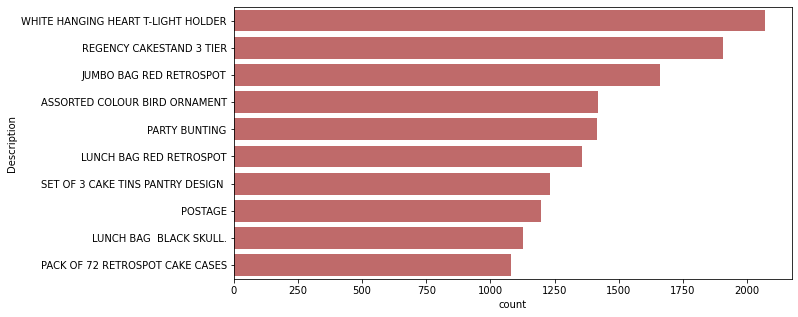

In [318]:
# Gráfica de los 10 objetos más vendidos
sns.barplot(x = 'StockCode', y = 'Description', data = description, color = 'indianred')
plt.xlabel('count')
plt.ylabel('Description')
plt.show()

### Reglas de Asociación

Deseamos obtener una lista de compras para cada cliente en cada fecha, es decir, los objetos comprados en cada transacción, para ello requerimos de las columnas CustomerID, Date y Description.

In [319]:
# extraemos un dataset con las columnas de interes
df_new = df_retail[['CustomerID', 'Date', 'Description']]

In [320]:
# Creamos una tabla pivot 
df_new_pivot = df_new.pivot_table(index = ['CustomerID', 'Date'], columns = 'Description', fill_value = 0, aggfunc = len)

In [321]:
# Si el valor es mayor a cero, significa que existe un objeto comprado de esa columna
df_new_pivot = df_new_pivot.reset_index(drop = True)
df_new_pivot = df_new_pivot > 0
df_new_pivot

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19291,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19292,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19293,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
19294,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [322]:
# Obtenemos los totales de cada columna
freq = {}
for column in df_new_pivot.columns:
  freq[column] = df_new_pivot[column].sum()
  

In [323]:
# Creamos un dataframe con la información sobre los totales de cada columna
freq = pd.DataFrame(list(freq.items()), columns = ['Object', 'Frequency'])

In [324]:
# Ordenamos los valores de mayor a menor y obtenemos los primeros 20
freq = freq.sort_values('Frequency', ascending = False).iloc[:20, :]

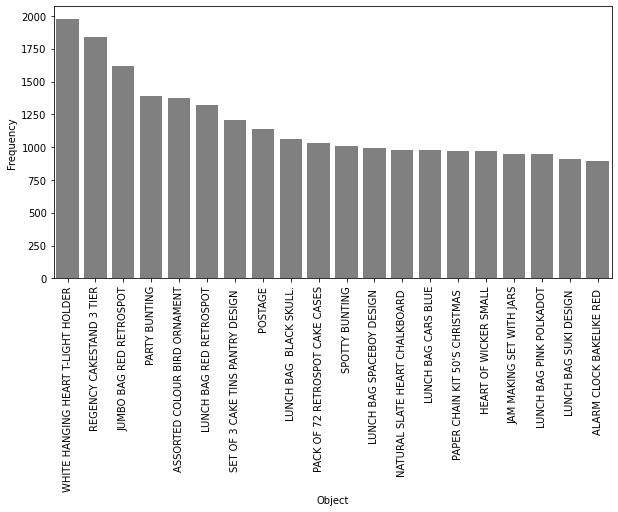

In [325]:
sns.barplot(x = 'Object', y = 'Frequency', data = freq, color = 'gray')
plt.xticks(rotation = 90)
plt.show()

### Algortimo Apriori

In [332]:
# Algoritmo Apriori con soporte minimo de 0.01 y longitud maxima de 3
frequent_itemset = apriori(df_new_pivot, min_support = 0.01, max_len = 3, use_colnames = True, n_jobs = -1)
frequent_itemset.sort_values(by = 'support', ascending = False).head(5)

,support,itemsets
566,0.102249,(WHITE HANGING HEART T-LIGHT HOLDER)
400,0.095460,(REGENCY CAKESTAND 3 TIER)
236,0.083903,(JUMBO BAG RED RETROSPOT)
325,0.071984,(PARTY BUNTING)
36,0.071362,(ASSORTED COLOUR BIRD ORNAMENT)


Aquí podemos observar  que los conjuntos de artículos comprados más frecuentemente están compuestos por un único objeto. 

In [336]:
 # Reglas deasociación
rules = association_rules(frequent_itemset, metric = 'lift', min_threshold = 1)
rules.sort_values(by = 'confidence', ascending = False).head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
505,(REGENCY TEA PLATE PINK),(REGENCY TEA PLATE GREEN ),0.011868,0.013993,0.010468,0.882096,63.040466,0.010302,8.362804
584,"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",(GREEN REGENCY TEACUP AND SAUCER),0.023062,0.037573,0.020263,0.878652,23.385466,0.019397,7.931115
578,"(PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",(GREEN REGENCY TEACUP AND SAUCER),0.016584,0.037573,0.014200,0.856250,22.789241,0.013577,6.695147
508,(REGENCY TEA PLATE PINK),(REGENCY TEA PLATE ROSES ),0.011868,0.017206,0.010158,0.855895,49.745041,0.009953,6.819997
474,(POPPY'S PLAYHOUSE LIVINGROOM ),(POPPY'S PLAYHOUSE KITCHEN),0.012956,0.017828,0.010987,0.848000,47.566884,0.010756,6.461661


El $88\%$ de las personas que compran REGENCY TEA PLATE PINK también incluyen en su compra REGENCY TEA PLATE GREEN. Mientras que el $87\%$ de quienes ordenan OSES REGENCY TEACUP AND SAUCER  también incluyen GREEN REGENCY TEACUP AND SAUCER. De hecho podemos concluir que las personas que incluyen un plato de té, incluirán en su compra otro plato de té. Esto puede resultar interesante a la hora de generar recomendaciones en la página.

* Los códigos obtenidos se entregarán vía el Moodle del diplomado junto con una reflexión sobre los
resultados obtenidos.

Reflexión:

En lo personal, este tipo de análisis me resultó bastante interesante, sin embargo, pienso que de querer obtener resultados más precisos, el costo computacional debe sumamente alto sobre todo en empresas que manejan una gran cantidad de artículos por compra. Sin embargo, es interesante el hecho de que existan relaciones entre nuestras acciones que se pueden detectar mediante un algoritmo. Pienso que es un algoritmo que tendría algunas aplicaciones bastante lucrativas, pero también es un algoritmo que puede aplicarse en cuestiones un tanto más sociales, por ejemplo, la detección de patrones de la delincuencia o los patrones que siguen personas que sufren ciertas enfermedades.

## Ejercicio 2

* Elegir un conjunto de datos del listado:
https://data.world/datasets/pca
Y aplicar PCA sobre el mismo para obtener las componentes más importantes

Se eligió el dataset: Principal Component Analysis - Pizza Dataset

In [132]:
# importando librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score

from mlxtend.plotting import plot_decision_regions

In [32]:
# Lectura de datos
df_pizza = pd.read_csv('/content/Pizza.csv')
df_pizza.head(3)

,brand,id,mois,prot,fat,ash,sodium,carb,cal
0,A,14069,27.82,21.43,44.87,5.11,1.77,0.77,4.93
1,A,14053,28.49,21.26,43.89,5.34,1.79,1.02,4.84
2,A,14025,28.35,19.99,45.78,5.08,1.63,0.80,4.95


In [59]:
df_pizza.shape

(300, 8)

Tenemos un dataset de $300$ filas y $8$ columnas.

In [33]:
df_pizza.isna().sum()

brand     0
id        0
mois      0
prot      0
fat       0
ash       0
sodium    0
carb      0
cal       0
dtype: int64

El dataset no cuenta con valores nulos

In [35]:
# Eliminamos la columna id, debido a que no aporta información y podría sobreajustar el modelo
df_pizza.drop('id', axis = 1, inplace = True)

In [34]:
# Obteniendo las diferentes marcas de pizza
df_pizza['brand'].unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype=object)

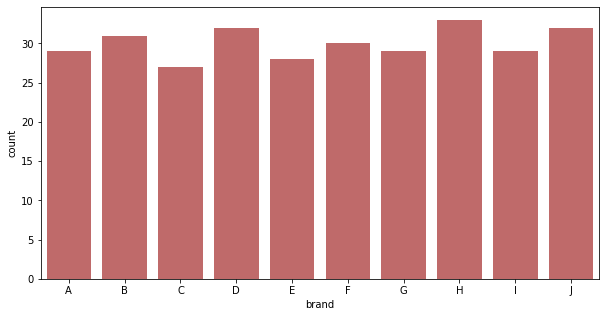

In [222]:
sns.countplot(x = 'brand', data = df_pizza, color = 'indianred')
plt.show()

In [90]:
# La variable target será "brand"
X = df_pizza.drop('brand', axis = 1).values
y = df_pizza['brand']

In [91]:
# Transformamos las diferentes categorias de "brand"  a valores númericos
y = LabelEncoder().fit_transform(y)

In [243]:
# Se divide el dataset en los conjuntos de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [244]:
# Estandarización de datos
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [245]:
cov_mat = np.cov(X_train_sc.T) # Matriz de covarianzas
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat) # Eigenvalores y Eigenvectores de lamatriz de covarianzas
print('Eigenvalores: ', eigen_vals)

Eigenvalores:  [4.19709328e+00 2.27871928e+00 4.22496145e-01 1.00570464e-01
 3.03809540e-02 2.57634332e-05 2.81625411e-06]


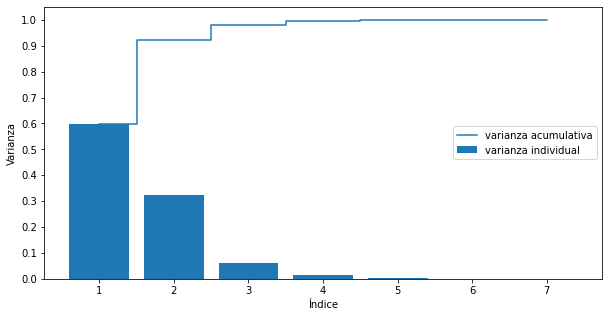

In [275]:
tot = sum(eigen_vals) # Suma de los eigenvalores
var_exp = [ev / tot for ev in sorted(eigen_vals, reverse  =True)] # Varianzas
cum_var_exp = np.cumsum(var_exp) # Suma acumulativa de la lista anterior
plt.bar(range(1, 8), var_exp, label = 'varianza individual', align = 'center') # Gráfica de la varianza
plt.step(range(1, 8), cum_var_exp, where = 'mid', label = 'varianza acumulativa') # Gráfica de la varianza acumlativa
plt.xlabel('Índice')
plt.xticks(list(range(1, 8)))
plt.yticks([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
plt.ylabel('Varianza')
plt.legend(loc = 5)
plt.show()

Podemos observar que dos componentes tienen $90\%$ de la información mientras que cinco componentes, tienen cerca del $100\%$ de la información, por lo que usaremos cinco componentes en PCA.

In [270]:
# Con base en lo observado entrenamos PCA con cinco componentes
pca = PCA(n_components = 5)

X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

In [271]:
# Entrenaremos un modelo de SVC con un GridSearchCV para obtener los parámetros óptimos
grid_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 20, 50 ],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
} # Definimos los parámetros que se probaran

grid = GridSearchCV(estimator = SVC(),
                    param_grid = grid_params,
                    cv = 5
                    ) # Preparación de GridSearchCV

grid.fit(X_train_pca, y_train) # Entrenamiento de GridSearchCV
clf = grid.best_estimator_ # Mejor estimador
print('Accuracy Score: ', clf.score(X_test_pca, y_test))
clf

Accuracy Score:  0.9166666666666666


SVC(C=20, kernel='linear')

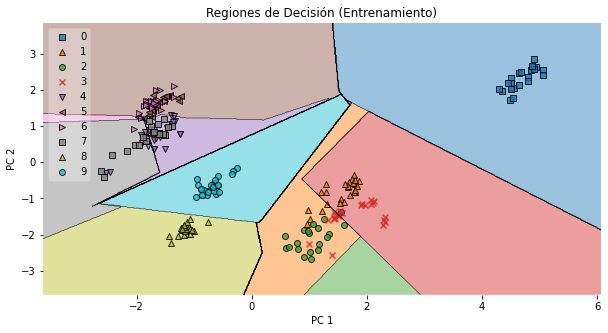

In [284]:
value = 0
width = 10
plot_decision_regions(X_train_pca, np.array(y_train), clf = clf, legend = 2,
                      filler_feature_values={2: value, 3: value, 4: value},
                      filler_feature_ranges={2: width, 3:width, 4: width}
                      )
plt.title('Regiones de Decisión (Entrenamiento)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

Se puede ver que algunos puntos no caen dentro de su categoría, dado el score, esto puede deberse a que esta gráfica es una proyección de un espacio de $5$ dimensiones. 



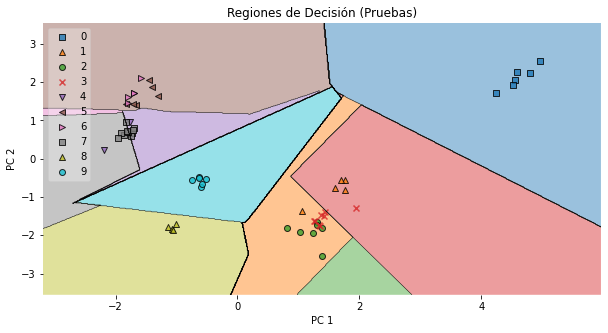

In [285]:
plot_decision_regions(X_test_pca, np.array(y_test), clf = clf, legend = 2,
                      filler_feature_values={2: value, 3: value, 4: value},
                      filler_feature_ranges={2: width, 3:width, 4: width})

plt.title('Regiones de Decisión (Pruebas)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [188]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

In [272]:
# Definimos un pipeline 
pipe = Pipeline([
                 ('scaler', StandardScaler()),
                 ('pca', PCA(n_components = 5)),
                 ('clf', clf)
])

In [273]:
# Cross-validation
kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42).split(X_train, y_train)
scores = []

for k, (train, test) in enumerate(kfold):
  pipe.fit(X_train[train], y_train[train])
  score = pipe.score(X_train[test], y_train[test])
  scores.append(score)

  print('Fold #{}, Tamaño: {}, Acc: {}'.format(k + 1,
                                               np.bincount(y_train[train]),
                                               score))

Fold #1, Tamaño: [20 24 18 22 23 22 22 19 22 24], Acc: 0.875
Fold #2, Tamaño: [21 24 18 22 23 22 21 19 22 24], Acc: 0.9166666666666666
Fold #3, Tamaño: [21 23 18 22 23 22 21 20 22 24], Acc: 1.0
Fold #4, Tamaño: [21 23 18 22 23 22 21 20 22 24], Acc: 1.0
Fold #5, Tamaño: [21 23 18 21 24 22 21 20 23 23], Acc: 0.9166666666666666
Fold #6, Tamaño: [21 23 18 21 24 21 22 20 23 23], Acc: 0.8333333333333334
Fold #7, Tamaño: [21 23 18 21 24 21 22 20 23 23], Acc: 0.9583333333333334
Fold #8, Tamaño: [21 23 18 21 24 21 22 20 23 23], Acc: 0.875
Fold #9, Tamaño: [20 24 18 22 23 21 22 20 23 23], Acc: 0.875
Fold #10, Tamaño: [20 24 18 22 23 22 22 20 22 23], Acc: 0.9166666666666666


In [274]:
print('Mean Acc CV: {} +/- {}'.format(np.mean(scores), np.std(scores)))

Mean Acc CV: 0.9166666666666666 +/- 0.05270462766947299


El accuracy del modelo es de $91\%$. 

* Los códigos obtenidos se entregarán vía el Moodle del diplomado junto con una reflexión sobre los
resultados obtenidos.

Reflexión:

En princio se aplicó PCA con dos componentes, las cuales tienen un $90\%$ de la información, sin embargo el accuracy obtenido fué de $0.81$. Por lo cual se puede concluir que hay información valiosa para las predicciones en el resto de componentes. Sin embargo al usar más de $5$ componentes el accuracy converge. Por lo cual, usar $5$ componentes resultó lo más óptimo. Si embargo, en este caso la gráfica de las regiones de decisión no resulta una manera óptima de comprobar la efectividad del modelo, debido a que lo que se obtiene es una gráfica que es la proyección de un espacio de mayor dimensión, por lo cual se recurrió a cross-validation, donde se obtuvó un accuracy de $91\%$, por lo cual podemos decir que es bueno modelo.